In [345]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random as ra

In [346]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 1 #binary for whether it is digit or not
        
epochs = 10            
batch_size = 64
learning_rate = 0.001

In [347]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [348]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x): #x = input img
        x = x.view(x.size(0), -1)  #flatten img, because (batch_size, 1, 28, 28) and nn.Linear expects (batch_size, features)
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [349]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [350]:
file_pth = 'binary_ffn_3.pth'
net.load_state_dict(torch.load(file_pth)) #pre-trained
trained_dig = int(file_pth[-5])

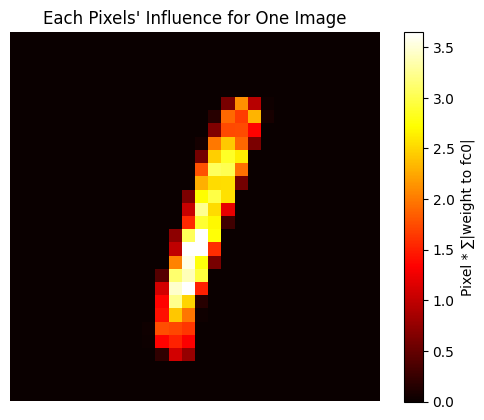

In [351]:
inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))
img = inputs[ind].squeeze() #[28, 28]

weights = net.fc0.weight.detach().cpu() #[32, 784]
importance = weights.abs().sum(dim=0).view(28, 28) #[28, 28]

activation_fc0 = img * importance #[28, 28] 

plt.imshow(activation_fc0, cmap='hot', vmin=0, vmax=activation_fc0.max())
plt.colorbar(label='Pixel * ∑|weight to fc0|')
plt.title("Each Pixels' Influence for One Image")
plt.axis('off')
plt.show()

In [352]:
#shows that often most areas of the digit are important, but if less is needed for a correct prediciton, weights do distribute accordingly

0: 5.1149115562438965
1: 0.0
2: 8.371903419494629
3: 1.1650457382202148
4: 0.0
5: 3.315462589263916
6: 3.252734661102295
7: 9.41694450378418
8: 4.351511001586914
9: 0.0
10: 9.153489112854004
11: 0.35230982303619385
12: 0.0
13: 5.1054277420043945
14: 12.387955665588379
15: 4.802644729614258
16: 0.0
17: 1.107713222503662
18: 0.0
19: 7.03855037689209
20: 3.5421836376190186
21: 0.8279874324798584
22: 6.23928165435791
23: 2.2409298419952393
24: 7.088949680328369
25: 1.350521445274353
26: 10.57130241394043
27: 0.0
28: 0.7757794857025146
29: 0.729345440864563
30: 3.995955467224121
31: 1.9322209358215332
torch.Size([32])


/tmp/ipykernel_7627/376033459.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


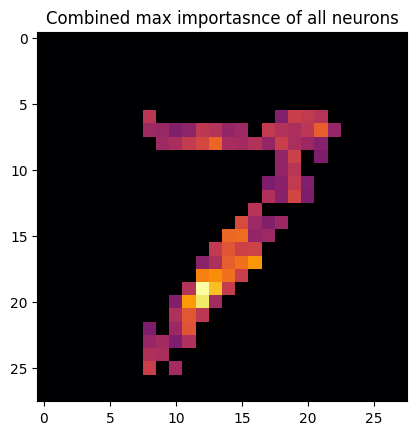

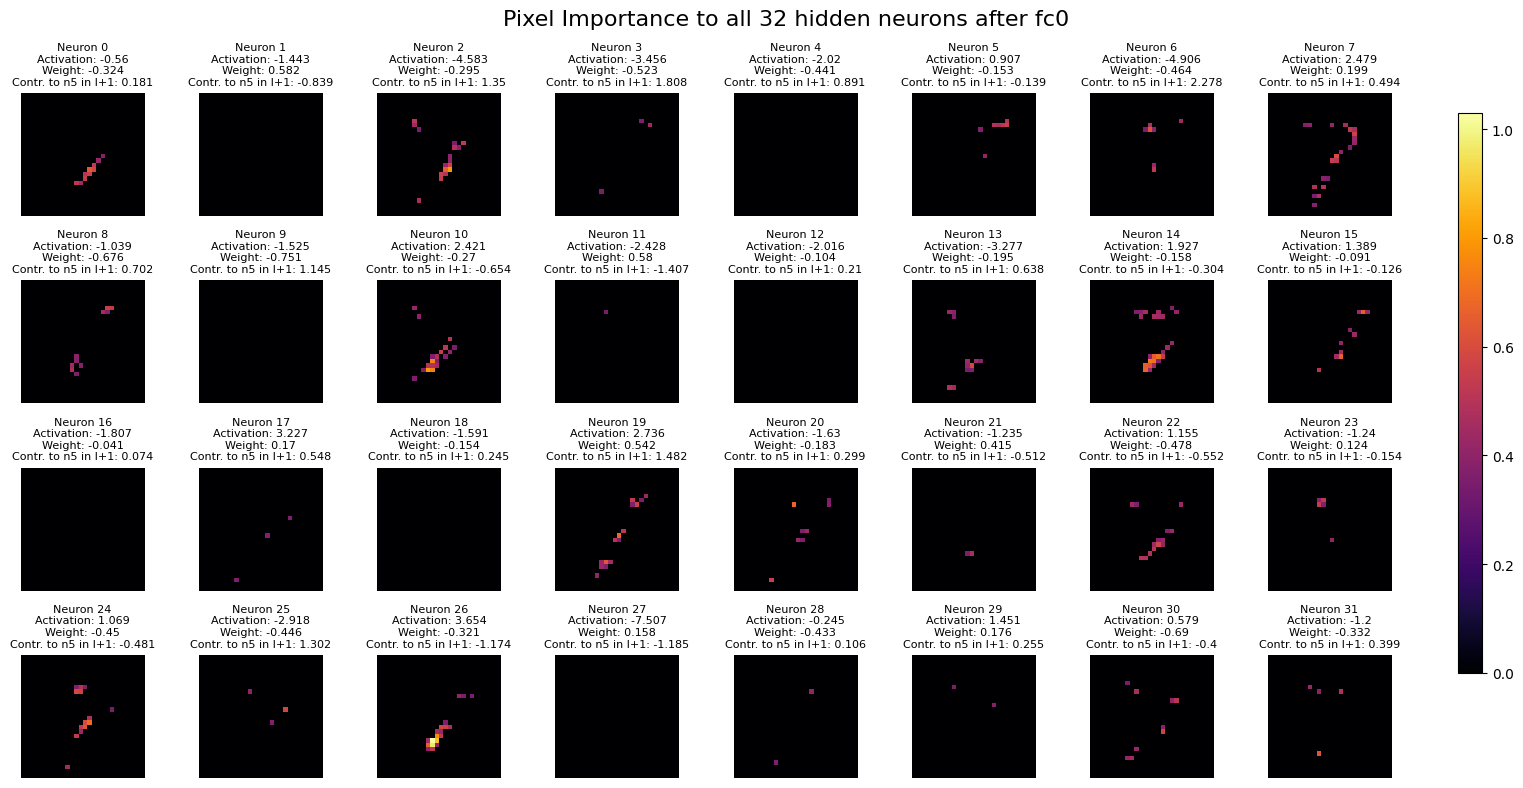

In [353]:

inputs, labels = next(iter(test_loader))
dig_to_check = 7

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break
    
#img = torch.full((28, 28), 255)

plt.imshow(img, cmap="inferno")
#plt.title(f"Predicted by net: {pred}")

img_flat = img.view(-1)

weights = net.fc0.weight.detach().cpu()
biases = net.fc0.bias.detach().cpu()
contribs = weights * img_flat #32, 784

#mask = (img_flat > 0).float()
#contribs = contribs * mask

#contribs = torch.clamp(contribs, min=0.0)

#normalise to [0, 1]
max_val = contribs.max()
contribs_norm = contribs / max_val
contribs_imgs = contribs_norm.view(-1, 28, 28)

mask = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    1
)

contribs_imgs += biases[:, None, None]
contribs_imgs *= mask #no bias where background = 0

contribs_imgs = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    torch.where(
        contribs_imgs > 0.35,
        contribs_imgs,
        torch.tensor(0.0, device=contribs_imgs.device)
    )
)

activation_modified = []
for i, mat in enumerate(contribs_imgs):
    mat = mat.sum().item()
    print(f"{i}: {mat}")
    activation_modified.append(mat)


#combo = contribs_imgs.sum(dim=0)
combo = contribs_imgs.max(dim=0).values

#normalise
#max_val = combo.max()
#combo /= max_val

"""combo = torch.where(
    combo == 0,
    torch.tensor(0.0, device=combo.device),
    torch.where(
        combo > 0.35,
        combo,
        torch.tensor(0.1, device=combo.device)
    )
)"""



"""for i, mat in enumerate(contribs_imgs):
    if i == 0:
        activations = mat.sum(dim=0)
        continue

    activations += mat.sum(dim=0)"""
#instead take actualy activaiton, this is modified for visuals!
activations = net.fc0(img.view(1, -1).cuda()).squeeze()

next_neuron_idx = 5

weights_to_neuron = net.fc1.weight[next_neuron_idx]
contribution = activations * weights_to_neuron
#next_contribs = contribution.sum(dim=1) #dim = 1 means y-axis, so all weights to neuron

#print(next_contribs.size())
print(weights_to_neuron.size())

plt.imshow(combo, cmap="inferno")
plt.title("Combined max importasnce of all neurons")

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

vmax = contribs_imgs.max().item()

for i, ax in enumerate(axes.flat):
    im = ax.imshow(contribs_imgs[i], cmap='inferno', vmin=0, vmax=vmax)
    ax.set_title(f'Neuron {i}\nActivation: {round(activations[i].item(), 3)}\nWeight: {round(weights_to_neuron[i].item(), 3)}\nContr. to n{next_neuron_idx} in l+1: {round(contribution[i].item(), 3)}', fontsize=8)
    ax.axis('off')

fig.suptitle('Pixel Importance to all 32 hidden neurons after fc0', fontsize=16)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [354]:
#activation function can be ignored, as it is ReLU and this image is normalise by setting negative value to 0 already!

In [355]:
#!NOTE TO SELF: ONCE DONE, REMOVE CERTAIN PATCHES FOR DECISIONS, TO SHOW THAT THIS PART WAS IMPORTANCE, AND USE EXAMPLE OF E.G., 3 VS 8 WHICH SHOULD BECOME HARDER THEN

In [356]:
#next steps planned for thu: segmenter for relevant patches, make class cinstruction for concepts, make indexing system to trace activations through FFN, start summariser system to reduce FFN, check FFN accuracy with reduced paths

In [357]:
"""import torch
import matplotlib.pyplot as plt

#Parameters
imgs = [x.clamp(0, 1) for x in contribs_imgs]
value_thresh = 0.9
loc_thresh = 3
groups = []
used = set()



for g_idx, group in enumerate(groups):
    plt.figure(figsize=(len(group)*2, 2))
    for idx, img_idx in enumerate(group):
        plt.subplot(1, len(group), idx + 1)
        plt.imshow(imgs[img_idx].squeeze(), cmap='inferno', vmin=0, vmax=1)
        plt.axis('off')
    plt.suptitle(f'Group {g_idx+1}')
    plt.tight_layout()
    plt.show()
"""
#for now leave away similarity clustering, maybe better after recombination

"import torch\nimport matplotlib.pyplot as plt\n\n#Parameters\nimgs = [x.clamp(0, 1) for x in contribs_imgs]\nvalue_thresh = 0.9\nloc_thresh = 3\ngroups = []\nused = set()\n\n\n\nfor g_idx, group in enumerate(groups):\n    plt.figure(figsize=(len(group)*2, 2))\n    for idx, img_idx in enumerate(group):\n        plt.subplot(1, len(group), idx + 1)\n        plt.imshow(imgs[img_idx].squeeze(), cmap='inferno', vmin=0, vmax=1)\n        plt.axis('off')\n    plt.suptitle(f'Group {g_idx+1}')\n    plt.tight_layout()\n    plt.show()\n"

In [358]:
#recombine in next layer l+1

In [359]:
weights_fc1 = net.fc1.weight.detach().cpu()
concepts = contribs_imgs

In [360]:
weights_exp = weights_fc1.unsqueeze(-1).unsqueeze(-1)
concepts_exp = concepts.unsqueeze(0)
combined = (weights_exp * concepts_exp).sum(dim=1)

In [361]:
#normalise to [0, 1]
max_val = combined.max()
combined = combined / max_val
#combined = combined.view(-1, 28, 28)

biases_fc1 = net.fc1.bias.detach().cpu()
combined += biases_fc1[:, None, None]

combined = torch.where(
    combined == 0,
    torch.tensor(0.0, device=combined.device),
    torch.where(
        combined > 0.35,
        combined,
        torch.tensor(0.1, device=combined.device)
    ) 
)

In [362]:
weights_fc2 = net.fc2.weight.detach().cpu()

In [363]:
import torch.nn.functional as F

In [364]:
with torch.no_grad():
    x = img.view(1, -1).cuda()
    a0 = F.tanh(net.fc0(x)) #using tanh because ReLU bad for explainability, issue because -a*(-w) = z > 0, but becomes 0 due to ReLU
    a1 = F.tanh(net.fc1(a0)) #would have been positive activation and useful to explanaiton
    logits_fc2 = net.fc2(a1)

print(a1.size())
print(f"out: {logits_fc2.item()}")
sign = 0 if logits_fc2.item() > 0 else 1
print(f"Net predicted img was {sign*'not '}a {trained_dig}")

torch.Size([1, 16])
out: 0.9799637794494629
Net predicted img was a 3


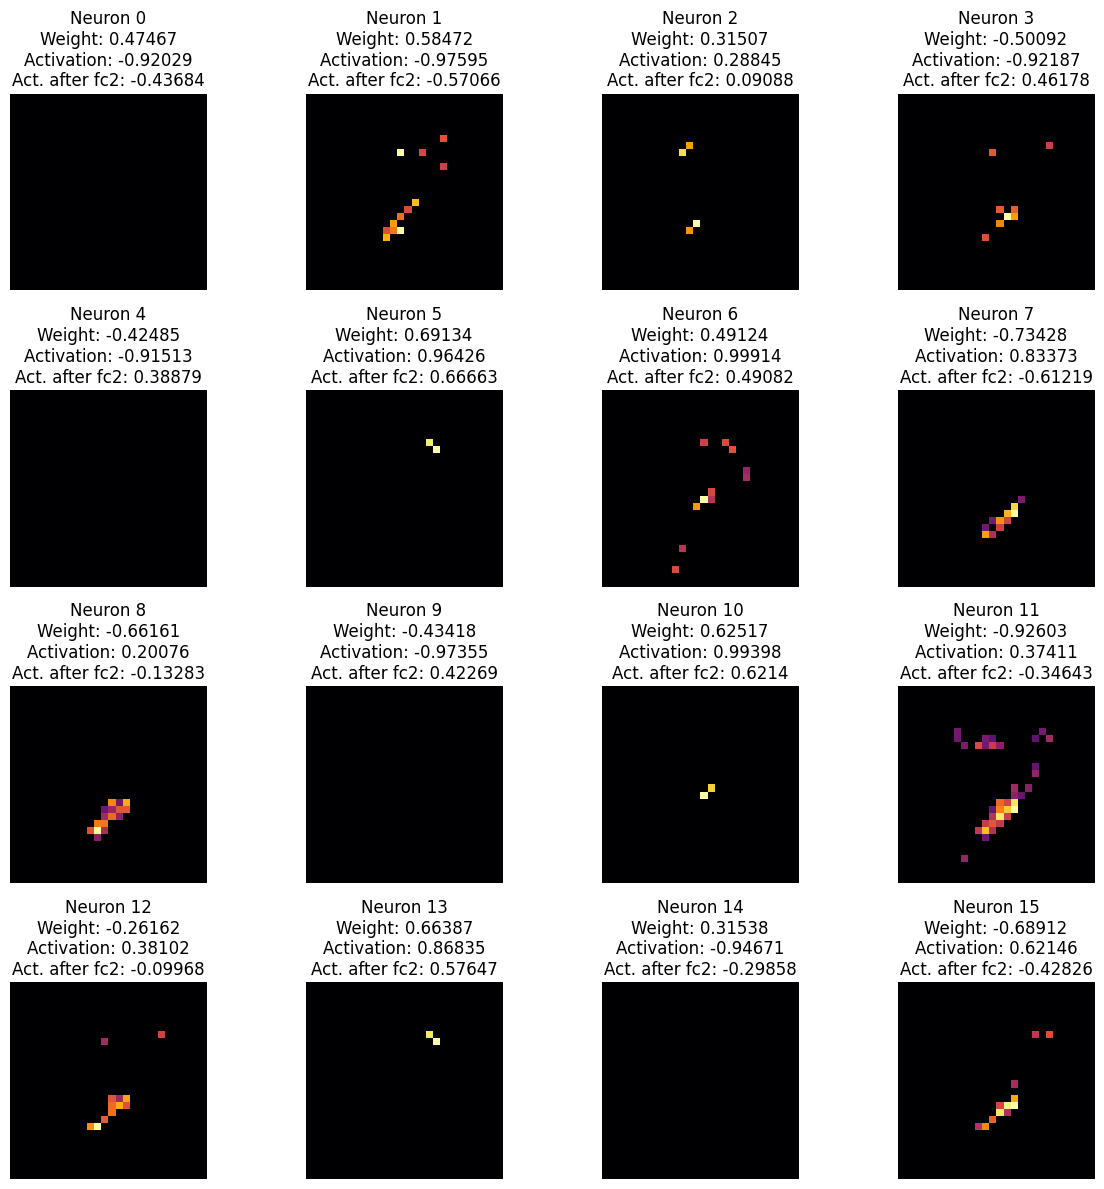

tensor([0.1860])


In [365]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):  
    ax.imshow(combined[idx].cpu(), cmap='inferno')
    ax.axis('off')
    ax.set_title(f'Neuron {idx}\nWeight: {round(weights_fc2[0][idx].item(), 5)}\nActivation: {round(a1[0][idx].item(), 5)}\nAct. after fc2: {round(weights_fc2[0][idx].item() * a1[0][idx].item(), 5)}')
plt.tight_layout()
plt.show()

bias_fc2 = net.fc2.bias.detach().cpu()
print(bias_fc2)

#concepts after fc1

In [366]:
#Important Note, I learned:
#A trait of a digit may contribute negatively to decision that it is that digit, and only in last layer flip sign to contribute positively, due to both negative weight and activation!
#clearly seen here!

#(unless using ReLU)

########################
#concepts for the trained digits have positive contribution, other negative, in principle teh net checks for the presence of these concepts

Idea: Trace back concepts from fc2 to fc1 and then label the importance of a concept (not just pixel values) in the input image, with a section color for clear conceptual and segmented explanation

In [367]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        mask = (labels == trained_dig)
        if not mask.any():
            continue
        images = images[mask]
        if CUDA:
            images = images.cuda()
        images = images.view(-1, 28*28)

        a0 = F.tanh(net.fc0(images))
        a1 = F.tanh(net.fc1(a0))
        logits = net.fc2(a1)
        predicted = (torch.sigmoid(logits) >= 0.5).float()

        correct += predicted.sum().item()
        total += images.size(0)

    print(f'Accuracy on digit {trained_dig} (manual pass with activations): {100 * correct / total:.2f} %')


Accuracy on digit 3 (manual pass with activations): 99.31 %


In [368]:
#note: before adjusting dataset not to be biased to many more non-bin_digit's in proportion, using ReLU was needed, 
#because it would make negative contributions that were only <0 because the net was biased, trained on uneven data, but now that the dataset is fixed,
#ReLU is hurting the explainability and tanh or even no activation function at all is giving higher accuracy!

Text(0.5, 1.0, 'most important 50% of pixels')

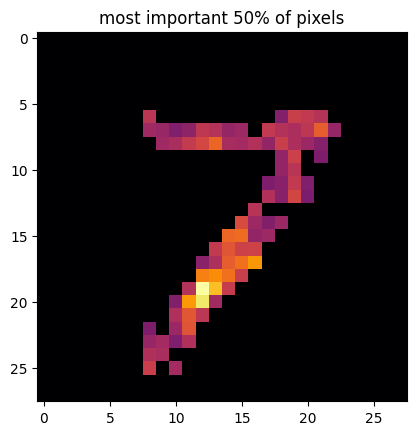

In [369]:
#input segmentation with importance, influence, color attribution in plot for clear overview, after that: implement recreation with new algorithm

combo = torch.where(
        combo > 0.0,
        combo,
        torch.tensor(0.0, device=combined.device)
    )

plt.imshow(combo, cmap="inferno")
plt.title("most important 50% of pixels")

#-> segment this

In [376]:
pixel_count = combo.view(-1).size()[0]
pixel_count_important = (combo > 0).sum().item()
segment_size = round(pixel_count_important * 0.075, 0)
pixel_count_important, segment_size

(89, 7.0)

In [377]:
imp_pixels = (combo > 0).nonzero(as_tuple=False) #tensor of coordiantes that aren't = 0

In [378]:
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.patches as mpatches

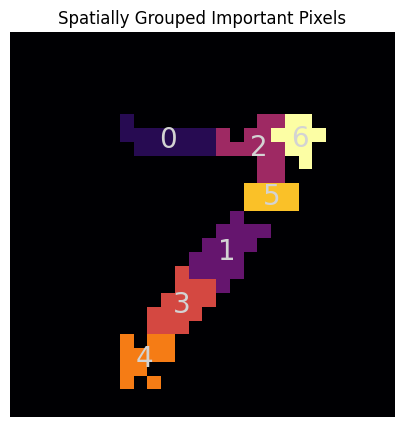

In [379]:
clusterer = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=segment_size,
    linkage='complete',
    metric='euclidean'
)
labels = clusterer.fit_predict(imp_pixels)

clusters = defaultdict(list)
for coord, label in zip(imp_pixels, labels):
    clusters[label].append(coord)

#making a map
label_map = torch.zeros((28, 28), dtype=torch.int32)
for label, coords in clusters.items():
    for y, x in coords:
        label_map[y, x] = label + 1

label_map_np = label_map.numpy()
unique_vals = np.unique(label_map_np)

plt.figure(figsize=(5, 5))
plt.imshow(label_map_np, cmap='inferno', interpolation='nearest')
plt.axis('off')
plt.title('Spatially Grouped Important Pixels')

for val in unique_vals:
    positions = np.argwhere(label_map_np == val)
    if positions.size == 0 or val == 0:
        continue
    centroid = positions.mean(axis=0)
    y, x = centroid
    plt.text(x, y, str(val-1), color='lightgray', fontsize=20, ha='center', va='center')

plt.show()


In [375]:
label_neuron_dict = {}

for label in set(labels):
    label_neuron_dict[label] = {}

for coord, label in zip(imp_pixels, labels):
    y, x = coord
    for idx, neuron_map in enumerate(contribs_imgs):
        val = neuron_map[y, x]
        if val > 0.6:
            label_neuron_dict[label][idx] = label_neuron_dict[label].get(idx, 0) + val


sorted_label_neuron = {
  label: sorted(neurons.items(), key=lambda item: item[1], reverse=True)
  for label, neurons in label_neuron_dict.items()
}
sorted_label_neuron

{0: [(26, tensor(4.3094)), (14, tensor(3.3665)), (10, tensor(2.2808))],
 1: [(31, tensor(0.6299))],
 2: [],
 3: [(2, tensor(1.4517)),
  (14, tensor(1.3634)),
  (24, tensor(1.2354)),
  (19, tensor(0.6827)),
  (15, tensor(0.6601)),
  (0, tensor(0.6417))],
 4: [(24, tensor(0.6924))],
 5: [],
 6: [(15, tensor(0.6570))],
 7: [],
 8: [(20, tensor(0.6772)), (6, tensor(0.6282))],
 9: [(19, tensor(0.6385))],
 10: [],
 11: [],
 12: []}